# Import

In [1]:
%load_ext autoreload
%autoreload 2

import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
plt.rcParams.update({"axes.grid" : True, "grid.color": "black", "grid.alpha":"0.25", "grid.linestyle": "--"})
plt.rcParams.update({'font.size': 14})

import LocalProjection

# Load data

In [2]:
with open('data/data.p', 'rb') as f:
    data = pickle.load(f)

# IRFs

In [3]:
IRFs = {}
IRFs['lp'] = {}
IRFs['slp'] = {}

**Setings:**

In [4]:
# a. shock
shockname = 'shock_MA'

# a. lists
base = ['log_INDPRO','log_PCEPI','log_CRBCPI','u']
rates = ['EU','UE']
event_probs = ['EU','UE']

# b. combined lists
endo = ['R'] + event_probs + ['u']
contemp = base #+ rates
exo = ['R',shockname] + base #+ rates

**Data:**

In [5]:
data_IRF = data[np.unique(endo+contemp+exo)] # create
data_IRF = data_IRF.dropna(axis=0,how='any') # remove nans
print(f'estimation period: {str(data_IRF.index[0])[:-12]} to {str(data_IRF.index[-1])[:-12]}')

estimation period: 1969-01 to 2007-12


**Compute:**

In [6]:
# a. settings
Nlags = 2 # lags of exogenous variables
H_min = 0 # = 0 -> recursivenes assumption
H_max = 48 # maximum horizon
r = 3 # r-1 is degree of polynomial, should be chosen by cross-validation
lambdaval = 10_000 # penalty term, should be chosen by cross-validation

# b. compute
for varname in endo:
    
    print(varname)
    
    # i. regular
    lp = LocalProjection.slp(data_IRF,varname,shockname,contemp,exo,
                             Nlags,H_min,H_max,smooth=True,r=r,lambdaval=1e-4)
    
    lp = LocalProjection.slp_conf(lp,H_max,lambdaval=1e-4)
    
    IRFs['lp'][varname] = lp.IRF
    IRFs['lp'][(varname,'L')] = lp.conf[:,0]
    IRFs['lp'][(varname,'U')] = lp.conf[:,1]

    # ii. smooth
    slp = LocalProjection.slp(data_IRF,varname,shockname,contemp,exo,
                              Nlags,H_min,H_max,smooth=True,r=r,lambdaval=lambdaval)
    
    IRFs['slp'][varname] = slp.IRF
    

R
EU
UE
u


# Figures

## Impulse-responses

### R ###


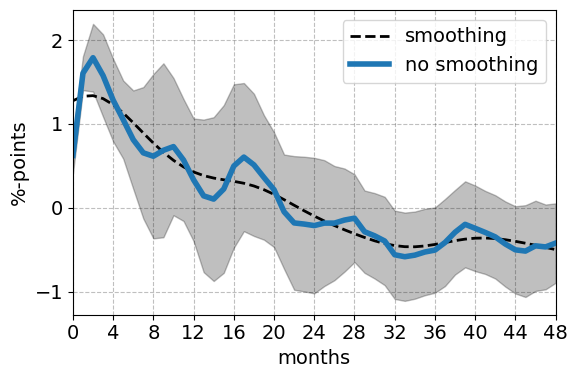

### EU ###


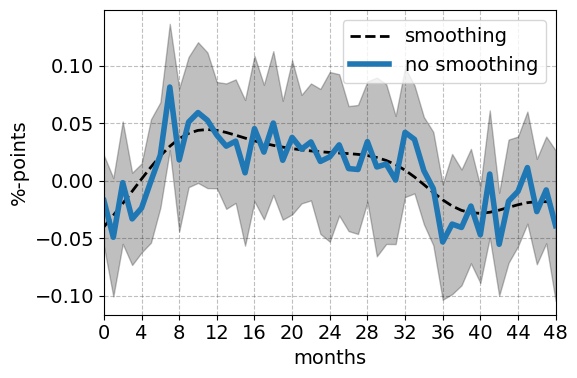

### UE ###


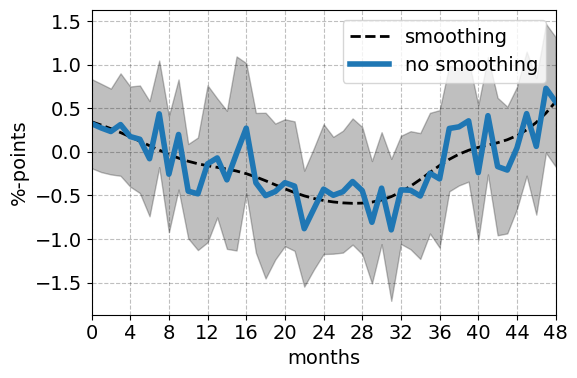

### u ###


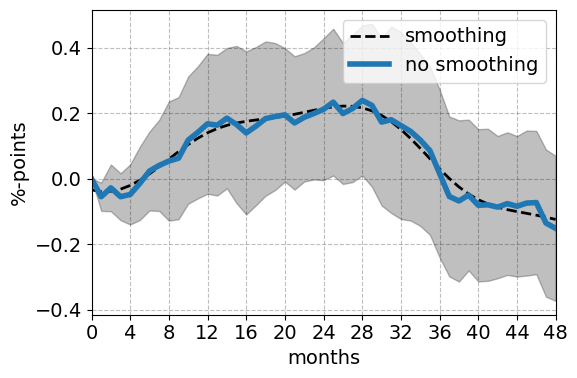

In [7]:
# a. settings
fac = 1.00/np.mean( IRFs['lp']['R'][:12])
fac_slp = 1.00/np.mean(IRFs['slp']['R'][:12])

# b. plots
for varname in endo:
    
    print(f'### {varname} ###')
    
    fig = plt.figure(figsize=(6,6/1.5))
    ax = fig.add_subplot(1,1,1)

    # a. unpack
    mean = fac* IRFs['lp'][varname]
    L = fac* IRFs['lp'][varname,'L']
    U = fac* IRFs['lp'][varname,'U']

    # b. plot
    
    # slp
    mean_slp = fac_slp*IRFs['slp'][varname]
    ax.plot(mean_slp,lw=2,color='black',ls='--',label=fr'smoothing')
    
    # lpirfs
    ax.fill_between(np.arange(mean.size),L,U,alpha=0.25,color='black')
    ax.plot(mean,lw=4,label='no smoothing')
    
    # c. details
    ax.set_xticks(np.arange(H_max+1)[::4])
    ax.set_xlim([0,H_max])
    ax.set_ylabel('%-points')
    ax.set_xlabel('months')
    
    ax.legend(frameon=True)

    fig.tight_layout()
    fig.savefig(f'results/monetary_shock_{varname}.pdf')
    plt.show()


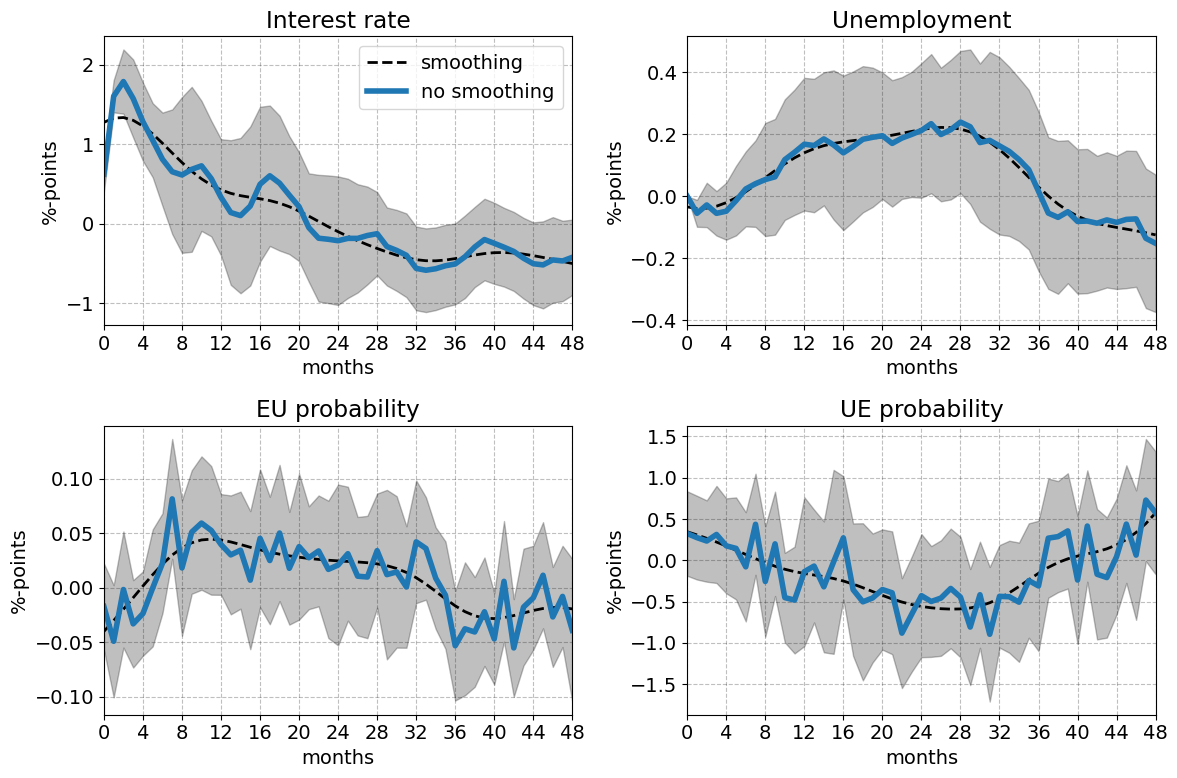

In [8]:
# a. settings
fac = 1.00/np.mean( IRFs['lp']['R'][:12])
fac_slp = 1.00/np.mean(IRFs['slp']['R'][:12])

fig = plt.figure(figsize=(12,12/1.5))
variables = ['R', 'u', 'EU', 'UE']
title_list = ['Interest rate', 'Unemployment', 'EU probability', 'UE probability']

# b. plots
for i, varname in enumerate(variables):
    ax = fig.add_subplot(2,2,i+1)

    # a. unpack
    mean = fac* IRFs['lp'][varname]
    L = fac* IRFs['lp'][varname,'L']
    U = fac* IRFs['lp'][varname,'U']

    # b. plot
    
    # slp
    mean_slp = fac_slp*IRFs['slp'][varname]
    ax.plot(mean_slp,lw=2,color='black',ls='--',label=fr'smoothing')
    
    # lpirfs
    ax.fill_between(np.arange(mean.size),L,U,alpha=0.25,color='black')
    ax.plot(mean,lw=4,label='no smoothing')
    
    # c. details
    ax.set_xticks(np.arange(H_max+1)[::4])
    ax.set_xlim([0,H_max])
    ax.set_ylabel('%-points')
    ax.set_xlabel('months')
    ax.set_title(title_list[i])
    
    if i == 0:
        ax.legend(frameon=True)

fig.tight_layout()
fig.savefig(f'results/monetary_shock_subplot.pdf')
plt.show()


## IRFs in levels

In [9]:
ss_EU = np.mean(data_IRF['EU'])
ss_UE = np.mean(data_IRF['UE'])
ss_u = 100*ss_EU/(ss_EU+ss_UE)

IRF_u = ss_u + fac_slp*IRFs['slp']['u']
IRF_EU = ss_EU + fac_slp*IRFs['slp']['EU']
IRF_UE = ss_UE + fac_slp*IRFs['slp']['UE']

## Lead-Lag

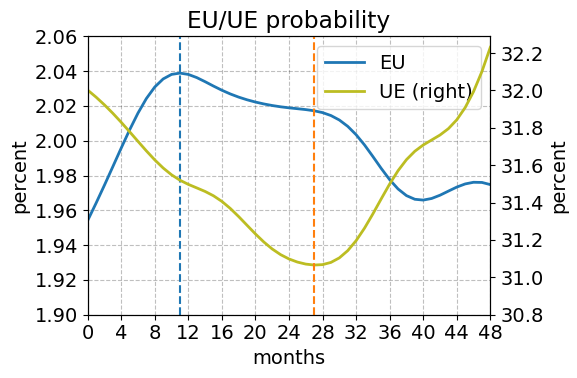

In [10]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

# left
ax.plot(IRF_EU,lw=2,color=colors[0],label=f'EU')
ax.axvline(np.argmax(IRF_EU),ls='--',color=colors[0])

# right
ax.plot(np.nan*np.ones(1),lw=2,color=colors[-2],label=f'UE (right)')

ax_r = ax.twinx()
ax_r.plot(IRF_UE,color=colors[-2],lw=2,label=f'EU')
ax_r.axvline(np.argmin(IRF_UE),ls='--',color=colors[1])
ax_r.grid(None)

# y-axis
ax.set_yticks(np.arange(1.9,2.06,0.02))
ax.set_ylabel('percent')

ax_r.set_yticks(np.arange(30.8,32.4,0.2))
ax_r.set_ylabel('percent')

# x-axis
ax.set_xticks(np.arange(H_max+1)[::4])
ax.set_xlim([0,H_max])
ax.set_xlabel('months')
ax.set_title('EU/UE probability')

# save
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(f'results/monetary_shock_lead_lag.pdf')
plt.show()

## Approximation error

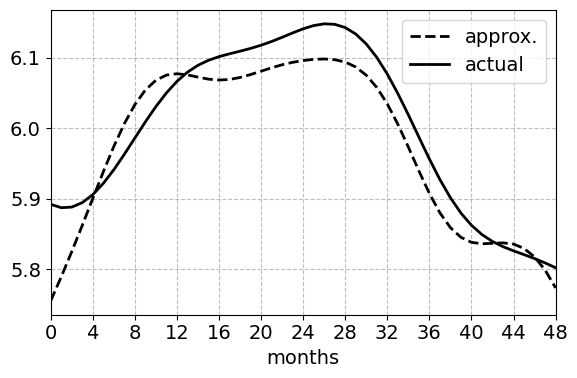

In [11]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

ax.plot(100*IRF_EU/(IRF_EU+IRF_UE),color='black',ls='--',lw=2,label=fr'approx.')
ax.plot(IRF_u,color='black',lw=2,label=f'actual')

# y-axis
ax.set_xlabel('percent')
              
# x-axis
ax.set_xticks(np.arange(H_max+1)[::4])
ax.set_xlim([0,H_max])
ax.set_xlabel('months')

# save
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(f'results/monetary_shock_approx_error.pdf')
plt.show()

## Decomposition

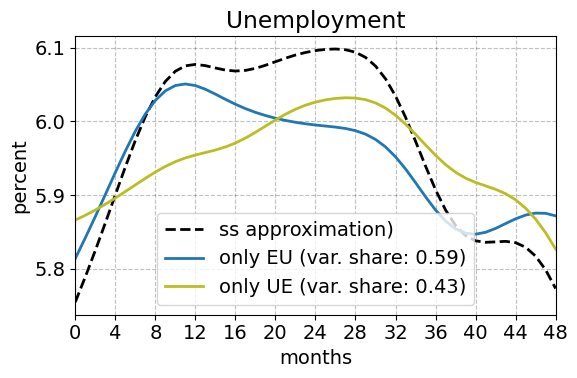

In [12]:
fig = plt.figure(figsize=(6,6/1.5))
ax = fig.add_subplot(1,1,1)

u_approx = 100*IRF_EU/(IRF_EU+IRF_UE)
u_EU = 100*IRF_EU/(IRF_EU+ss_UE)
u_UE = 100*ss_EU/(ss_EU+IRF_UE)

var_share_u_EU = np.cov(u_approx.T,u_EU.T)[0,1]/np.var(u_approx)
var_share_u_UE = np.cov(u_approx.T,u_UE.T)[0,1]/np.var(u_approx)

ax.plot(u_approx,color='black',lw=2,ls='--',label=fr'ss approximation)')

ax.plot(u_EU,color=colors[0],lw=2,label=f'only EU (var. share: {var_share_u_EU:.2f})')
ax.plot(u_UE,color=colors[-2],lw=2,label=f'only UE (var. share: {var_share_u_UE:.2f})')

ax.set_xticks(np.arange(H_max+1)[::4])
ax.set_xlim([0,H_max])
ax.set_xlabel('months')
ax.set_ylabel('percent')
ax.set_title('Unemployment')

# save
ax.legend(frameon=True)
fig.tight_layout()
fig.savefig(f'results/monetary_shock_decomposition.pdf')
plt.show()

In [13]:
with open('saved/monetary_IRF.pickle', 'wb') as f:
    pickle.dump({'u_approx':u_approx,'u_EU':u_EU,'u_UE':u_UE,'var_share_u_EU':var_share_u_EU,'var_share_u_UE':var_share_u_UE},f)